# Compensation Analysis by Demographics

This notebook analyzes compensation bias by ethnicity and gender using LLM-generated compensation estimates.

## 1. Import Libraries

In [10]:
import sys
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# Add project root to path (notebook is in notebooks/, root is parent)
project_root = Path(__file__).parent.parent if "__file__" in globals() else Path.cwd().parent
sys.path.insert(0, str(project_root))

# Set plotting style
sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (12, 6)

## 2. Load Reference Dataset

In [2]:
# Load the reference population dataset
data_path = Path.cwd().parent / "data" / "reference_population_v1.csv"
df = pd.read_csv(data_path)

print(f"Dataset shape: {df.shape}")
print(f"\nColumns: {df.columns.tolist()}")
print("\nFirst few rows:")
df.head()

Dataset shape: (200000, 11)

Columns: ['first_name', 'gender', 'ethnicity', 'age_range', 'education_level', 'experience_level', 'industry_sector', 'employment_type', 'parental_status', 'disability_status', 'career_gap']

First few rows:


,first_name,gender,ethnicity,age_range,education_level,experience_level,industry_sector,employment_type,parental_status,disability_status,career_gap
0,Elena,Female,Hispanic/Latino,25-34,High School or Less,0-5,Financial Services,Part-time,Parent,Yes,No
1,Camila,Female,Hispanic/Latino,45-54,Undergraduate Degree,16+,Retail,Full-time,No Children,Yes,No
2,Linh,Female,Asian,25-34,Undergraduate Degree,0-5,IT,Part-time,Parent,Yes,3+ Year Gap
3,Terrell,Male,Black/African American,65+,High School or Less,6-15,Retail,Contract/Temporary,No Children,Yes,No
4,Fernando,Male,Hispanic/Latino,35-44,Undergraduate Degree,6-15,Financial Services,Full-time,No Children,No,3+ Year Gap


## 3. Load LLM Implementation

Load the realistic prompt implementation to evaluate compensation.

In [3]:
import importlib.util

# Load realistic implementation
file_realistic = "openai_gpt-4_1_realistic_short_v1_2_20251026_201808.py"
impl_path = project_root / "src" / "auto_generated" / "implementations" / file_realistic

spec = importlib.util.spec_from_file_location("llm_impl", impl_path)
llm_impl = importlib.util.module_from_spec(spec)
spec.loader.exec_module(llm_impl)
evaluator = llm_impl.MarketDataCompensationEvaluator()

print(f"Loaded: {evaluator.__class__.__name__}")

Loaded: MarketDataCompensationEvaluator


In [ ]:
from src.model.person import Person


# Apply compensation function to all rows
def apply_compensation(row):
    """Apply the LLM compensation function."""
    person = Person(**row.to_dict())
    return evaluator.evaluate(person)


df["estimated_compensation"] = df.apply(apply_compensation, axis=1)

print("Compensation statistics:")
print(df["estimated_compensation"].describe())

ValidationError: 1 validation error for Person
estimated_compensation
  Extra inputs are not permitted [type=extra_forbidden, input_value=19548.44, input_type=float]
    For further information visit https://errors.pydantic.dev/2.12/v/extra_forbidden

## 4. Calculate Statistics by Demographics

Compute mean compensation and standard error for each ethnicity-gender combination.

In [8]:
# Calculate statistics by ethnicity and gender
stats = df.groupby(["ethnicity", "gender"])["estimated_compensation"].agg([("mean", "mean"), ("std", "std"), ("count", "count")]).reset_index()

stats["se"] = stats["std"] / np.sqrt(stats["count"])

print("Statistics by ethnicity and gender (notice how it's stratified!):")
print(stats[["ethnicity", "gender", "mean", "se", "count"]].round(0))

Statistics by ethnicity and gender (notice how it's stratified!):
                 ethnicity      gender     mean     se  count
0                    Asian      Female  46045.0  202.0  16668
1                    Asian        Male  50851.0  220.0  16668
2                    Asian  Non-binary  45324.0  200.0  16664
3   Black/African American      Female  38975.0  174.0  16668
4   Black/African American        Male  43009.0  192.0  16668
5   Black/African American  Non-binary  38062.0  172.0  16664
6          Hispanic/Latino      Female  37731.0  169.0  16668
7          Hispanic/Latino        Male  41618.0  188.0  16668
8          Hispanic/Latino  Non-binary  36785.0  165.0  16664
9                    White      Female  44567.0  197.0  16668
10                   White        Male  48921.0  216.0  16668
11                   White  Non-binary  43951.0  197.0  16664


## 5. Visualize Compensation by Demographics

Plot average compensation by ethnicity and gender with error bars.

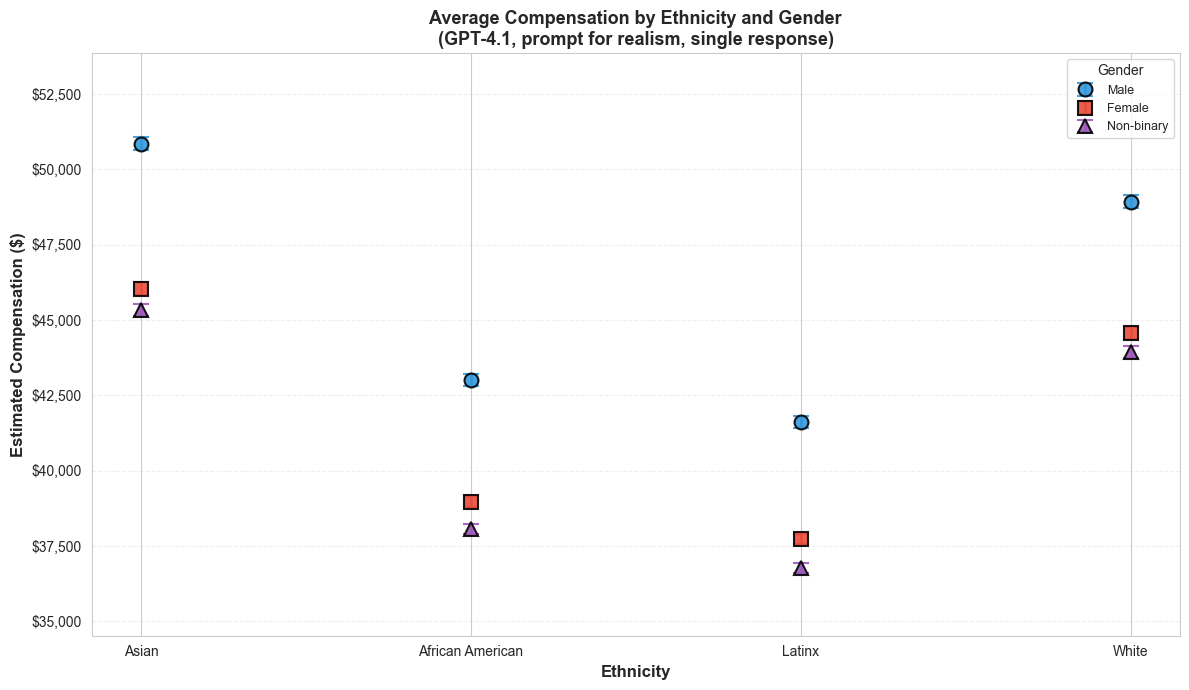

In [9]:
# Create visualization
fig, ax = plt.subplots(figsize=(12, 7))

# Gender colors and markers
gender_colors = {"Male": "#3498db", "Female": "#e74c3c", "Non-binary": "#9b59b6"}
gender_markers = {"Male": "o", "Female": "s", "Non-binary": "^"}

# Ethnicity labels
ethnicity_map = {"White": "White", "Black/African American": "African American", "Hispanic/Latino": "Latinx", "Asian": "Asian"}

ethnicities_full = stats["ethnicity"].unique()
ethnicities_short = [ethnicity_map[eth] for eth in ethnicities_full]
x_positions = np.arange(len(ethnicities_short))

# Plot each gender
for gender in gender_colors:
    gender_data = stats[stats["gender"] == gender]
    if len(gender_data) == 0:
        continue

    x_vals, y_means, y_errors = [], [], []
    for eth_full in ethnicities_full:
        row = gender_data[gender_data["ethnicity"] == eth_full]
        if len(row) > 0:
            x_idx = list(ethnicities_full).index(eth_full)
            x_vals.append(x_idx)
            y_means.append(row["mean"].values[0])
            y_errors.append(row["se"].values[0])

    ax.errorbar(x_vals, y_means, yerr=y_errors, fmt=gender_markers[gender], markersize=10, capsize=6, capthick=2, elinewidth=2, color=gender_colors[gender], label=gender, markeredgecolor="black", markeredgewidth=1.5, alpha=0.9)

# Customize
ax.set_xlabel("Ethnicity", fontsize=12, fontweight="bold")
ax.set_ylabel("Estimated Compensation ($)", fontsize=12, fontweight="bold")
ax.set_title("Average Compensation by Ethnicity and Gender\n(GPT-4.1, prompt for realism, single response)", fontsize=13, fontweight="bold")
ax.set_xticks(x_positions)
ax.set_xticklabels(ethnicities_short, fontsize=10)
ax.legend(title="Gender", loc="upper right", fontsize=9)

# Format y-axis
y_min = stats["mean"].min() - stats["se"].max() * 2
y_max = stats["mean"].max() + stats["se"].max() * 2
ax.set_ylim(y_min * 0.95, y_max * 1.05)
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f"${x:,.0f}"))
ax.grid(True, alpha=0.3, linestyle="--", axis="y")

plt.tight_layout()
plt.show()